# Filtro de Kalman
### Ampliación de robótica

En este apartado consideraremos el modelo dinámico con buena observabilidad de la velocidad

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import randn

In [2]:
xm = np.arange(0, 400, 1)
ym = np.zeros(400)
x_r = np.zeros(400)
y_r = np.zeros(400)
y1 = np.arange(0,200,1)
y2 = np.arange(200,0,-1)

In [3]:
for i in range (0,400):
    if i<200:
        ym[i] = y1[i]
    else:
        ym[i] = y2[i-200]

In [4]:
#plt.plot(xm,ym)

In [5]:
q = 2

for i in range(0,400):
    x_r[i] = xm[i] + q*np.random.randn();
    y_r[i] = ym[i] + q*np.random.randn();
    
#plt.plot(x_r,y_r,xm,ym)

![Imagen](kalman.png)

![Imagen](ses1.png)

## Vector de estados 

$$x_k= \left[ \matrix{ x \\ y \\ \dot x \\ \dot y} \right] = \matrix{ \text{Posicion X} \\ \text{Posicion Y} \\ \text{Velocidad X} \\ \text{Velocidad Y}}$$

$$x_{k+1} = \begin{bmatrix}1 & 0 & T & 0 \\ 0 & 1 & 0 & T \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ \dot x \\ \dot y \end{bmatrix}_{k}$$

### Incertidumbre inicial $P_0$
$$P_{0} = \begin{bmatrix}\sigma^2_x & 0 & 0 & 0 \\ 0 & \sigma^2_y & 0 & 0 \\ 0 & 0 & \sigma^2_{\dot x} & 0 \\ 0 & 0 & 0 & \sigma^2_{\dot y} \end{bmatrix}$$

$\sigma$ :Desviacion estandar

In [6]:
P = np.diag([10.0, 10.0, 10.0, 10.0])

### Matriz Dinámica $A$


$$x_{k+1} = x_{k} + \dot x_{k} \cdot \Delta t$$
$$y_{k+1} = y_{k} + \dot y_{k} \cdot \Delta t$$
$$\dot x_{k+1} = \dot x_{k}$$
$$\dot y_{k+1} = \dot y_{k}$$

In [7]:
T = 0.1
x = np.matrix([[0.0, 0.0, 0.0, 0.0]]).T
A = np.matrix([[1.0, 0.0, T, 0.0],
              [0.0, 1.0, 0.0, T],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])


### Matriz de Medidas $H$

$$H = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & -T & 0 \\ 0 & 0 & 0 & -T \end{bmatrix}$$

In [8]:
H = np.matrix([[1.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0],
               [1.0, 0.0,  -T, 0.0],
               [0.0, 1.0, 0.0,-T]])
print(H, H.shape)

[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 1.   0.  -0.1  0. ]
 [ 0.   1.   0.  -0.1]] (4, 4)


### Medida de la convarianza del Ruido $R$

Le dice al filtro como de malo son las medidas del sensor

$$R = \begin{bmatrix}\sigma^2_{\dot x} & 0 \\ 0 & \sigma^2_{\dot y} \end{bmatrix}$$

In [9]:
r = 2

R = np.matrix([[r*r, 0.0, 0.0, 0.0],
              [0.0, r*r, 0.0, 0.0],
              [0.0,0.0, r*r, 0.0],
               [0.0, 0.0, 0.0, r*r]])

print(R, R.shape)

[[4. 0. 0. 0.]
 [0. 4. 0. 0.]
 [0. 0. 4. 0.]
 [0. 0. 0. 4.]] (4, 4)


### Ruido en la medida: $Q$

$$Q = \begin{bmatrix}q² & 0 & 0 & 0 \\ 0 & q² & 0 & 0 \\ 0 & 0 & 2q & 0 \\ 0 & 0 & 0 & 2q \end{bmatrix}$$



In [10]:
q = 4

Q = np.matrix([[q*q, 0.0, 0.0, 0.0],
              [0.0, q*q, 0.0, 0.0],
              [0.0,0.0, 2*q, 0.0],
               [0.0, 0.0, 0.0, 2*q]])


In [11]:
I = np.eye(4)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


### Medidas

In [12]:
m = 400
mx = np.zeros(400)
my = np.zeros(400)
vx = np.zeros(400)
vy = np.zeros(400)
xant = np.zeros(400)
yant = np.zeros(400)

for i in range(1,400):
    vx[i] = (x_r[i]-x_r[i-1])/T
    vy[i] = (y_r[i]-y_r[i-1])/T
    
    xant[i] = x_r[i-1]
    yant[i] = y_r[i-1]
    i = i + 1



medidas = np.vstack((x_r,y_r,xant,yant))
print(medidas.shape)

(4, 400)


In [13]:
# Inicializamos las variables
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []
 

## Algoritmo Filtro de Kalman

In [14]:
for n in range(1,len(medidas[0])):

    # Prediccion
    x = A*x
    P = A*P*A.T + Q

    # Correccion
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    # Actualizamos
    Z = medidas[:,n].reshape(4,1)                           
    x = x + (K*(Z-(H*x))) # Innovacion

    # Actualizamos el error de la covarianzaz. 
    P = (I - (K*H))*P


    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))  

(-23.134604002162586, 421.2082438398811, -13.07366704964842, 209.6727056614896)

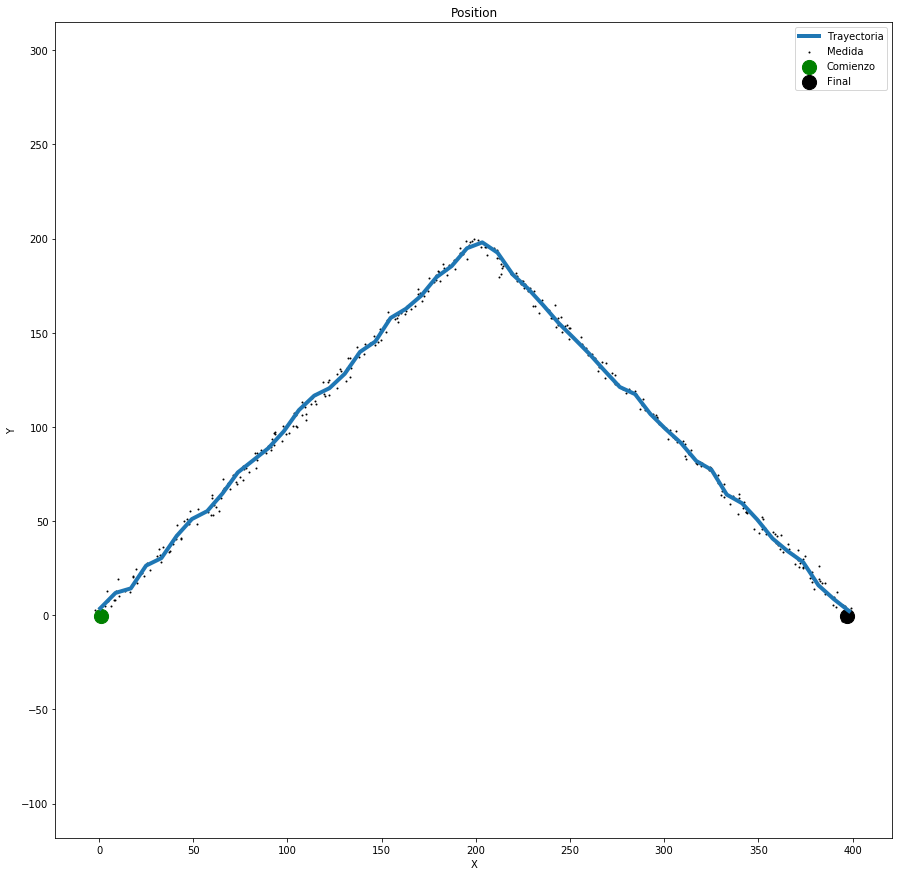

In [15]:
from scipy.interpolate import interp1d

f1 = interp1d(xt, yt, kind='nearest')
f2 = interp1d(xt, yt, kind='linear')
f3 = interp1d(xt, yt, kind='cubic')

xx = np.linspace(min(xt),max(xt))


fig = plt.figure(figsize=(15,15))
plt.scatter(x_r,y_r, s=1,marker='o',label='Medida', c='k')
plt.scatter(xt[0],yt[0], s=200, label='Comienzo', c='g')
plt.scatter(xt[-1],yt[-1], s=200, label='Final', c='k')
#plt.plot(x_r,y_r, 'bo')
plt.plot(xx, f2(xx), '-',linewidth=4,label='Trayectoria')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')

(-95.8340516849787, 425.28888000407085, -129.1493617720734, 112.11089387412177)

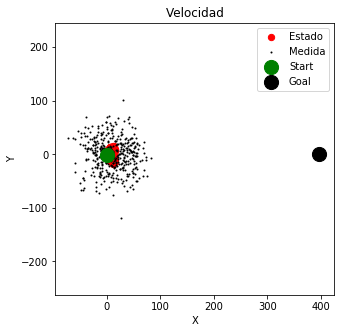

In [16]:
fig = plt.figure(figsize=(5,5))
plt.scatter(dxt,dyt, s=40, label='Estado', c='r')
plt.scatter(vx,vy, s=1, label='Medida', c='k')
plt.scatter(xt[0],yt[0], s=200, label='Start', c='g')
plt.scatter(xt[-1],yt[-1], s=200, label='Goal', c='k')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Velocidad')
plt.legend(loc='best')
plt.axis('equal')